## Improt Libraries

In [8]:
import re
import numpy as np 
import pandas as pd
import random
import math
import cv2 
import seaborn as sns
from glob import glob
import os
from pathlib import Path
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input,LeakyReLU,BatchNormalization,Dropout
from tensorflow.nn import atrous_conv2d
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim,mean_squared_error as mse
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [9]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dataset

In [11]:
#global_path = 'C:/Users/lenovo/Downloads/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*.png' 
path = '/content/drive/My Drive/BUS_Images/*/*.png' 
image_path = glob(path)
image_path.sort()
print(len(image_path))

1579


## Preprocessing

In [12]:
# creating dictionary of images and masks
image = []
masked_image = []
count = 1
i = 0
num = len(image_path)
images_with_class = {}
while i < num-1:
    print(str(count) + "/" + str(num), end="\r")
    img = image_path[i]
    a = Path(img).parts
    # get label from image name
    label=(a[-2])
    # get image name
    image_name = img.split('/')[-1].split(')')[0]
    if label not in images_with_class.keys():
        # make nested dictionory for each label
        images_with_class[label] = {'Original_Image':[],'Mask_Image':[]} 
    if img.split('/')[-1][-5] == ')':
        # get the image 
        image = cv2.resize(cv2.imread(img,cv2.IMREAD_GRAYSCALE),(128,128))
        images_with_class[label]['Original_Image'].append(image)
        mylist = image_path[i:]
        # get the masked_image
        r = re.compile(r".*"+re.escape(image_name)+r"\)_mask*.") 
        masklist = list(filter(r.match, mylist))
        if len(masklist) == 1:
            masked_image = cv2.resize(cv2.imread(masklist[0]),(128,128))            
            images_with_class[label]['Mask_Image'].append(masked_image)
        else:  #there are two masks
            masked_1 = cv2.imread(masklist[0])
            masked_2 = cv2.imread(masklist[1])
            masked_image = cv2.resize(cv2.bitwise_or(masked_1,masked_2),(128,128))            
            images_with_class[label]['Mask_Image'].append(masked_image)  
            
        
    i+=1 
    
    count += 1
   

## Classifiaction of images

In [14]:
# Number of images per class
labels = []
for keys,values in images_with_class.items():
    #print(value)
    for key,value in values.items():
        (labels.extend([key]*len(value)))
  
        print("{0} : {1} : {2} ".format(keys,key, len(value)))

benign : Original_Image : 437 
benign : Mask_Image : 437 
malignant : Original_Image : 210 
malignant : Mask_Image : 210 
normal : Original_Image : 133 
normal : Mask_Image : 133 


## Plot some sample images

Text(0.5, 1.0, 'Masked_Image')

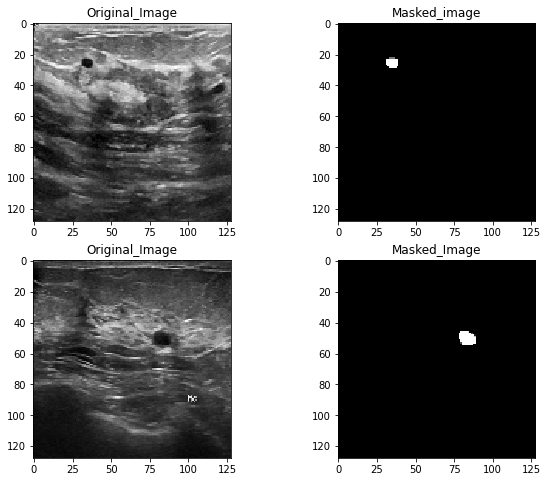

In [15]:
fig,axis = plt.subplots(2,2)
axis[0,0].imshow(images_with_class['benign']['Original_Image'][50])
axis[0,0].set_title('Original_Image')
axis[0,1].imshow(images_with_class['benign']['Mask_Image'][50])
axis[0,1].set_title('Masked_image')
axis[1,0].imshow(images_with_class['benign']['Original_Image'][100])
axis[1,0].set_title('Original_Image')
axis[1,1].imshow(images_with_class['benign']['Mask_Image'][100])
axis[1,1].set_title('Masked_Image')

## Creating dataset

In [16]:
#dataset for denoising consists of only images
dataset = images_with_class['benign']['Original_Image'] + images_with_class['malignant']['Original_Image'] + images_with_class['normal']['Original_Image']
#normalizing pixel values in the dataset
# The main purpose of the normallization is to make computation efficient by reducing values between 0 and 1. 
dataset = [img/255 for img in dataset] # for faster computation
random.shuffle(dataset) # this function shuffles the dataset randomly

In [17]:
# Function to plotting set of images
def plot(dataset):
  fig,axis=plt.subplots(1,4)
  fig.set_size_inches(10,10)
  for i in range(50,54):
    axis[i-50].imshow(dataset[i])
  plt.show()

## Adding noise to the dataset images

In [18]:
## adding speckle noise to the dataset 
noisy_dataset=[]
for image in dataset:
  # Introducing speckle noise
  noise =random_noise(image,mode = 'speckle') 
  noisy_dataset.append(noise)
dataset = np.array(dataset)
noisy_dataset = np.array(noisy_dataset)

In [19]:
len(noisy_dataset)

780

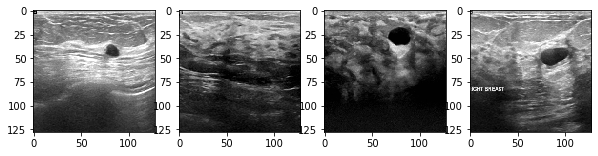

In [20]:
plot(dataset)

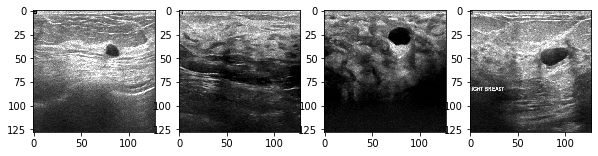

In [21]:
plot(noisy_dataset)

In [22]:
# Splitting dataset for training and testing
x_train = dataset[:624]
x_test = dataset[624:]
x_train_noisy = noisy_dataset[:624]
x_test_noisy= noisy_dataset[624:]

## Building Model Architecture

In [23]:
def denoising_autoencoder():
    i=Input(shape=(128,128,1))
    #encoder 
    x = Conv2D(128, (3,3), activation='relu', padding='same')(i)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)

    #decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

    #model
    autoencoder = Model(inputs=i, outputs=x)
    autoencoder.compile(optimizer='Adam', loss='mse',metrics=['accuracy'])
    autoencoder.summary()

    return autoencoder

In [24]:
## Model 
autoencoder = denoising_autoencoder()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584

## Training

In [25]:
Epochs = 200
Batch_size = 64
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('/content/drive/MyDrive/results/network.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
#learning_rate_red1 = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.8, min_lr=1e-10)
call_backs = [checkp]
# r = autoencoder.fit(x_train, x_train,
#                 epochs=Epochs,
#                 batch_size=Batch_size,
#                 shuffle=True,
#                 validation_data=(x_test, x_test),
#                 callbacks=[call_backs],verbose=0)
# # #model evaluation
# # print("Train score:", autoencoder1.evaluate(x_train_noisy,x_train_noisy))
# # print("Test score:", autoencoder1.evaluate(x_test_noisy,x_test_noisy))


Epoch 1: val_loss improved from inf to 0.02058, saving model to /content/drive/MyDrive/results/network.h5

Epoch 2: val_loss improved from 0.02058 to 0.01331, saving model to /content/drive/MyDrive/results/network.h5

Epoch 3: val_loss improved from 0.01331 to 0.00922, saving model to /content/drive/MyDrive/results/network.h5

Epoch 4: val_loss improved from 0.00922 to 0.00795, saving model to /content/drive/MyDrive/results/network.h5

Epoch 5: val_loss improved from 0.00795 to 0.00722, saving model to /content/drive/MyDrive/results/network.h5

Epoch 6: val_loss improved from 0.00722 to 0.00635, saving model to /content/drive/MyDrive/results/network.h5

Epoch 7: val_loss improved from 0.00635 to 0.00623, saving model to /content/drive/MyDrive/results/network.h5

Epoch 8: val_loss improved from 0.00623 to 0.00552, saving model to /content/drive/MyDrive/results/network.h5

Epoch 9: val_loss did not improve from 0.00552

Epoch 10: val_loss improved from 0.00552 to 0.00517, saving model t

In [26]:
#autoencoder.save('/content/drive/MyDrive/results/network.h5')

In [27]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/results/network.h5")

In [28]:
#model.evaluate(x_test, x_test)

In [29]:
y_pred = model.predict(x_test)
print(y_pred.shape)

(156, 128, 128, 1)


In [39]:
y_pred_x_train = model.predict(x_train)
print(y_pred_x_train.shape)

(624, 128, 128, 1)


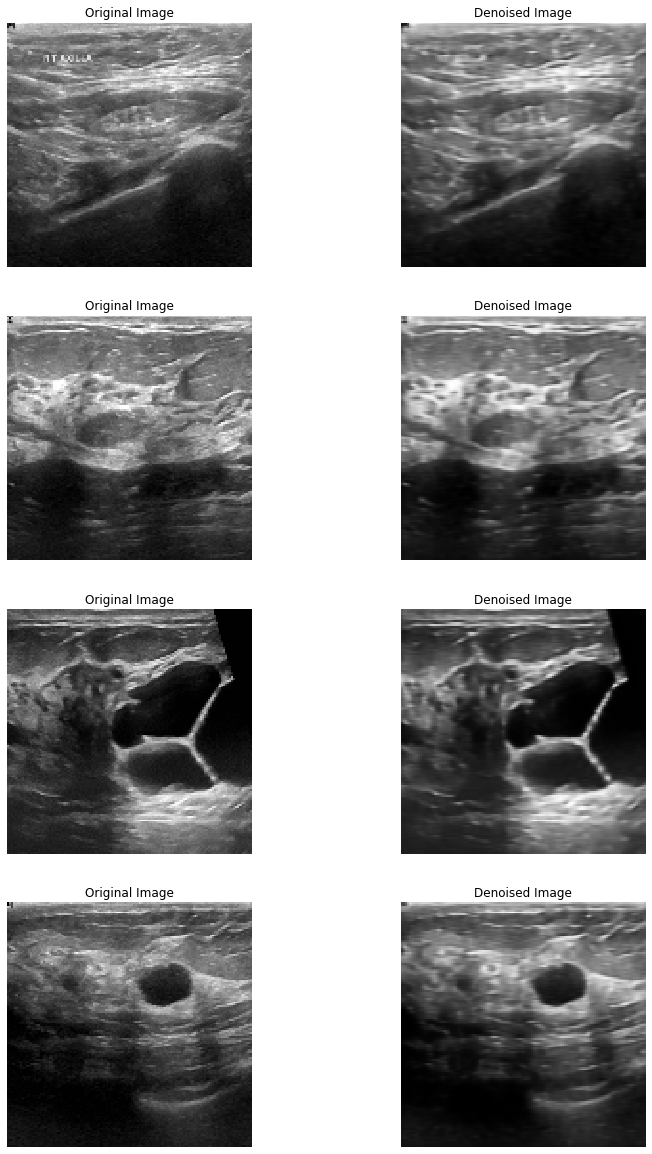

In [30]:
plt.figure(figsize = (20,80))
i = 0
x = 0
while i < 10 :   
    plt.subplot(15,3,i+1)
    plt.imshow(x_test[x], 'gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(15,3,i+2)
    plt.imshow(y_pred[x].reshape(128,128), 'gray')
    plt.title('Denoised Image')
    plt.axis('off')
    x += 1
    i += 3
plt.show()

In [31]:
#pred= autoencoder.predict(x_test[:155])

Text(0.5, 1.0, 'Denoise_Image-4')

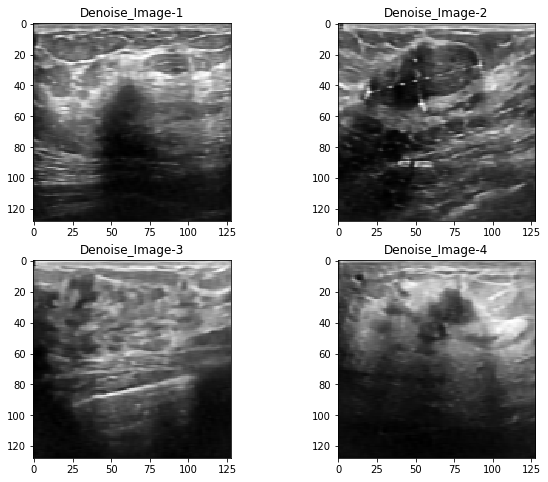

In [32]:
fig,axis = plt.subplots(2,2)
axis[0,0].imshow(y_pred[45].reshape(128,128))
axis[0,0].set_title('Denoise_Image-1')
axis[0,1].imshow(y_pred[10].reshape(128,128))
axis[0,1].set_title('Denoise_Image-2')
axis[1,0].imshow(y_pred[56].reshape(128,128))
axis[1,0].set_title('Denoise_Image-3')
axis[1,1].imshow(y_pred[5].reshape(128,128))
axis[1,1].set_title('Denoise_Image-4')

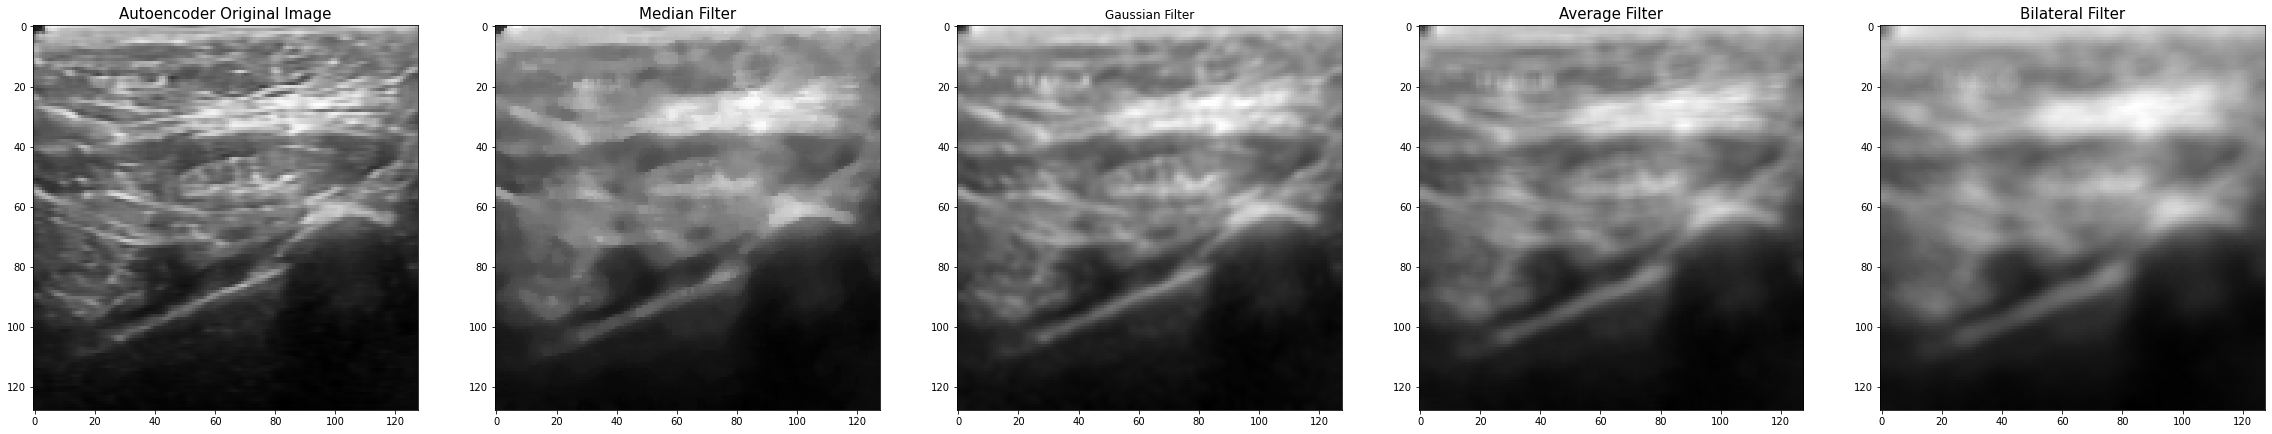

In [33]:
## comparing the denoised original image with other filters
median_blur = cv2.medianBlur(np.float32(x_test[0]), (5))
gaussian_blur=cv2.GaussianBlur(x_test[0],(5,5),0)
average_blur=cv2.blur(x_test[0],(5,5))
bilateral_filter=cv2.bilateralFilter(np.float32(x_test[0]),9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(y_pred[0].reshape(128,128), cmap='gray')
ax[0].set_title('Autoencoder Original Image',fontsize = 15)
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter',fontsize = 15)
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter',fontsize = 15)
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter',fontsize = 15)
plt.show()

In [34]:
## function to plot the curve between loss and epochs(Original Images) 
def plotLearningCurve(history,Epochs,Batch_size):
  epochRange = range(1,Epochs+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'],'m',label = 'Training Loss')
  plt.plot(epochRange,history.history['val_loss'],'g',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('LOSS, Epochs={}, Batch={}'.format(Epochs, Batch_size))
  plt.show()

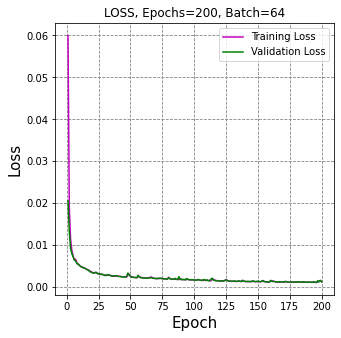

In [35]:
plotLearningCurve(r,Epochs,Batch_size)

In [36]:
value1 = psnr(x_test[0], y_pred[0].reshape(x_test[0].shape[0],-1))
value2 = psnr(x_test[0], median_blur)
value3 = psnr(x_test[0], gaussian_blur)
value4 = psnr(x_test[0], average_blur)
value5 = psnr(x_test[0], bilateral_filter)
metric = pd.DataFrame({'Autoencoder':value1,'Median Blur':value2,'Gaussian Blur':value3,'Average Blur':value4,'Bilateral Filter':value5},index = ['PSNR'])
value1 = mse(x_test[0], y_pred[0].reshape(x_test[0].shape[0],-1))
value2 = mse(x_test[0], median_blur)
value3 = mse(x_test[0], gaussian_blur)
value4 = mse(x_test[0], average_blur)
value5 = mse(x_test[0], bilateral_filter)
metric.loc['MSE'] = [value1,value2,value3,value4,value5]
value1 = ssim(x_test[0], y_pred[0].reshape(x_test[0].shape[0],-1))
value2 = ssim(x_test[0], median_blur)
value3 = ssim(x_test[0], gaussian_blur)
value4 = ssim(x_test[0], average_blur)
value5 = ssim(x_test[0], bilateral_filter)
metric.loc['SSIM'] = [value1,value2,value3,value4,value5]
metric

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


,Autoencoder,Median Blur,Gaussian Blur,Average Blur,Bilateral Filter
PSNR,29.903905,24.541210,26.666644,24.292824,23.466523
MSE,0.001022,0.003515,0.002154,0.003721,0.004501
SSIM,0.937220,0.771586,0.860819,0.751745,0.693240


In [43]:
# store_images='/content/drive/My Drive/Denoised_Images' 
# os.chdir(store_images)
# for i in range (0,156):
#   plt.imshow(y_pred[i].reshape(128,128),cmap='gray')
#   plt.grid(False)
#   plt.axis('off')
#   plt.savefig('Denoised_Images_'+str(i)+'.png')

In [42]:
# store_images='/content/drive/My Drive/Denoised_Image1' 
# os.chdir(store_images)
# for i in range (1,625):
#   plt.imshow(y_pred_x_train[i].reshape(128,128),cmap='gray')
#   plt.grid(False)
#   plt.axis('off')
#   plt.savefig('Denoised_Images_'+str(i)+'.png')

For Noisy image


In [ ]:
def denoise_autoencoder():
    i=Input(shape=(128,128,1))
    #encoder 
    x = Conv2D(128, (3,3), activation='relu', padding='same')(i)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)

    #decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

    #model
    autoencoder = Model(inputs=i, outputs=x)
    autoencoder.compile(optimizer='Adam', loss='mse',metrics=['accuracy'])
    autoencoder.summary()

    return autoencoder

In [ ]:
## Model 
autoencoder1 = denoise_autoencoder()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 128)     1280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 128)       1475

In [ ]:
Epochs1 = 200
Batch_size1 = 64
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('/content/drive/MyDrive/results/network1.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
#learning_rate_red1 = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.8, min_lr=1e-10)
call_backs = [checkp]
# r = autoencoder1.fit(x_train_noisy, x_train_noisy,
#                 epochs=Epochs1,
#                 batch_size=Batch_size1,
#                 shuffle=True,
#                 validation_data=(x_test_noisy, x_test_noisy),
#                 callbacks=[call_backs],verbose=0)
# # #model evaluation
# # print("Train score:", autoencoder1.evaluate(x_train_noisy,x_train_noisy))
# # print("Test score:", autoencoder1.evaluate(x_test_noisy,x_test_noisy))

In [ ]:
#autoencoder1.save('/content/drive/MyDrive/results/network1.h5')

In [ ]:
from keras.models import load_model
model1 = load_model("/content/drive/MyDrive/results/network1.h5")

In [ ]:
#model1.evaluate(x_test_noisy, x_test_noisy)

In [ ]:
y_pred1 = model1.predict(x_test_noisy)
print(y_pred1.shape)

(156, 128, 128, 1)


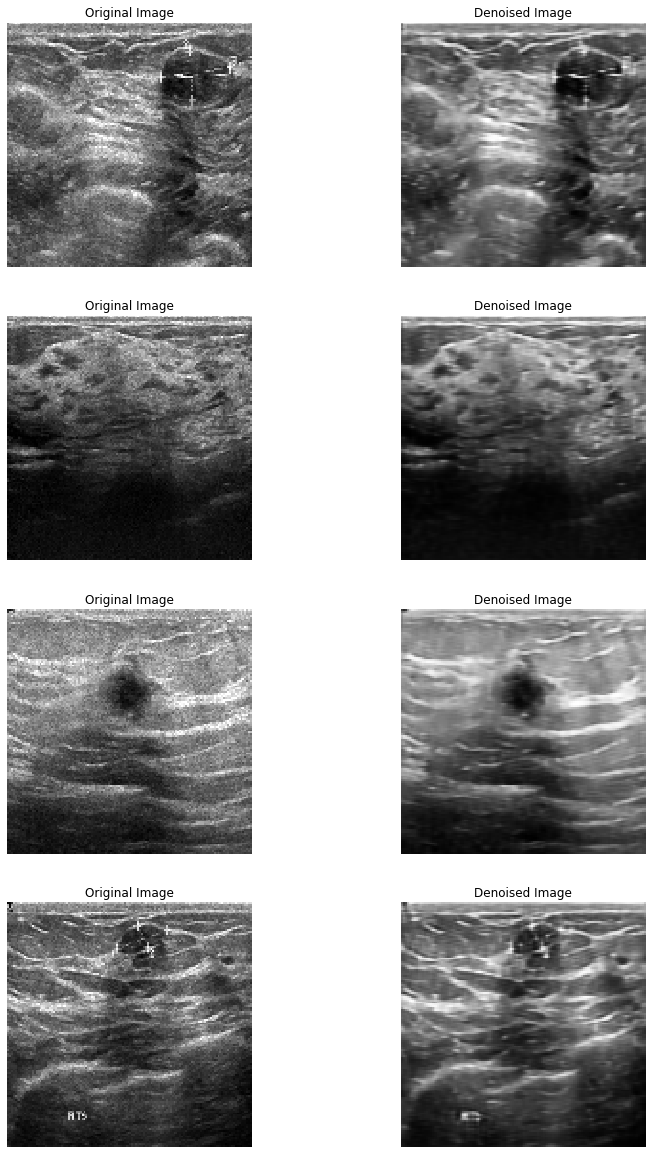

In [ ]:
plt.figure(figsize = (20,80))
i = 0
x = 0
while i < 10 :   
    plt.subplot(15,3,i+1)
    plt.imshow(x_test_noisy[x], 'gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(15,3,i+2)
    plt.imshow(y_pred1[x].reshape(128,128), 'gray')
    plt.title('Denoised Image')
    plt.axis('off')
    x += 1
    i += 3
plt.show()

In [ ]:
#pred1= autoencoder1.predict(x_test[:155])

In [ ]:
# #address='I:/New/xyz'
# D1='/content/drive/My Drive/Denoised_Image1' 
# os.chdir(D1)
# for i in range (0,10):
#   #     Img_name.replace(Img_name,f"no {1500+i}.jpg")
#   plt.imshow(pred1[i].reshape(128,128),cmap='gray')
#   plt.grid(False)
#   plt.axis('off')
#   plt.savefig('pred1'+str(i)+'.png')

## Plot the Predicted Images

Text(0.5, 1.0, 'Denoised_image-4')

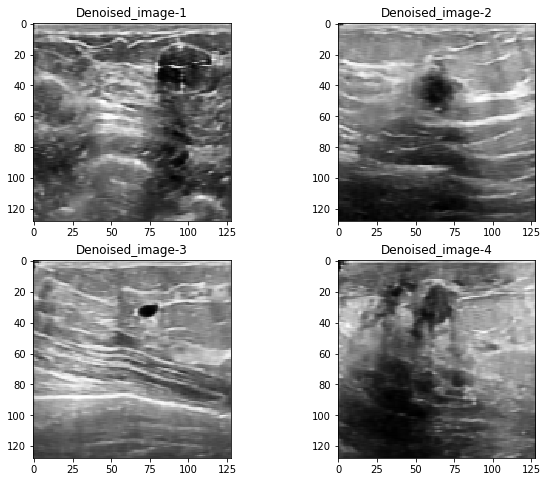

In [ ]:
fig,axis = plt.subplots(2,2)
axis[0,0].imshow(y_pred1[0].reshape(128,128))
axis[0,0].set_title('Denoised_image-1')
axis[0,1].imshow(y_pred1[2].reshape(128,128))
axis[0,1].set_title('Denoised_image-2')
axis[1,0].imshow(y_pred1[5].reshape(128,128))
axis[1,0].set_title('Denoised_image-3')
axis[1,1].imshow(y_pred1[6].reshape(128,128))
axis[1,1].set_title('Denoised_image-4')

## Comparison with other filters

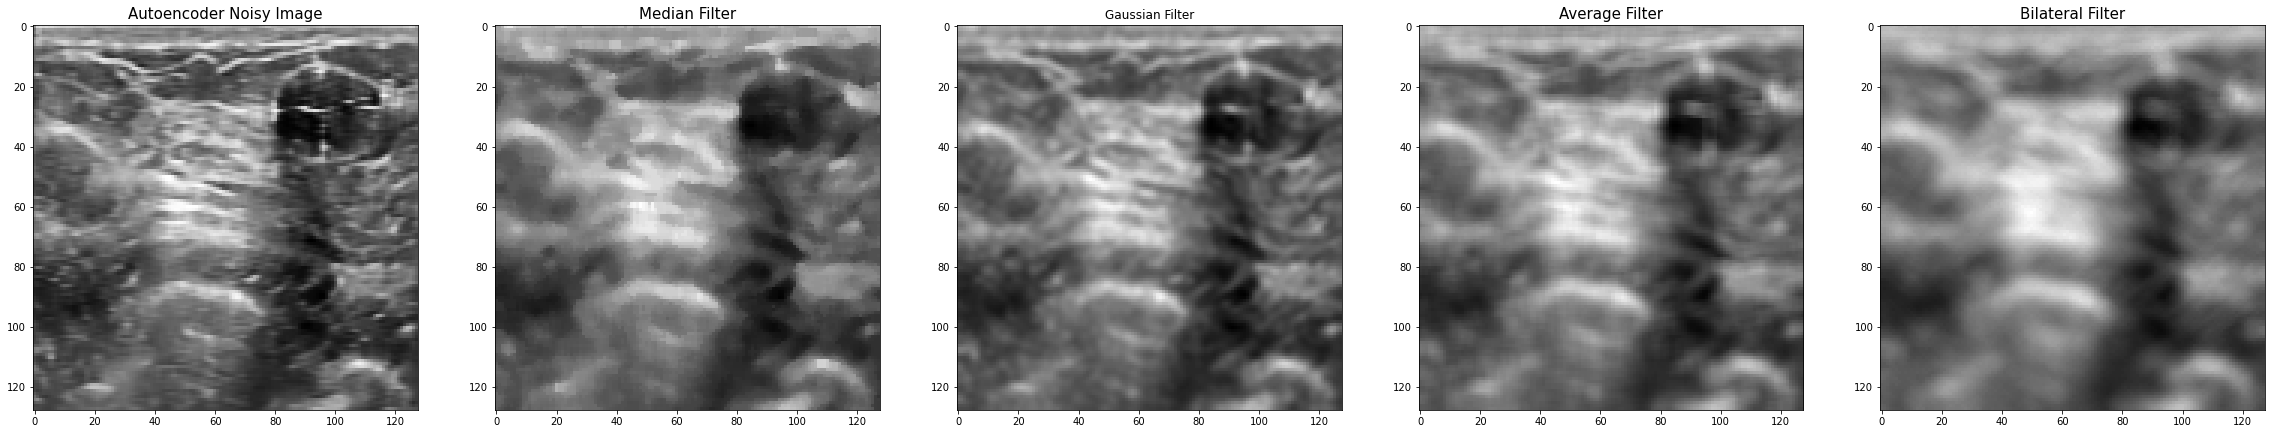

In [ ]:
## comparing the denoised noisy image with other filters
median_blur1 = cv2.medianBlur(np.float32(x_test_noisy[0]), (5))
gaussian_blur1=cv2.GaussianBlur(x_test_noisy[0],(5,5),0)
average_blur1=cv2.blur(x_test_noisy[0],(5,5))
bilateral_filter1=cv2.bilateralFilter(np.float32(x_test_noisy[0]),9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(y_pred1[0].reshape(128,128), cmap='gray')
ax[0].set_title('Autoencoder Noisy Image',fontsize = 15)
ax[1].imshow(median_blur1,cmap='gray')
ax[1].set_title('Median Filter',fontsize = 15)
ax[2].imshow(gaussian_blur1,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur1,cmap='gray')
ax[3].set_title('Average Filter',fontsize = 15)
ax[4].imshow(bilateral_filter1,cmap='gray')
ax[4].set_title('Bilateral Filter',fontsize = 15)
plt.show()

In [ ]:
## function to plot the curve between loss and epochs(Noisy Images)
def plotLearningCurve1(history,Epochs1,Batch_size1):
  epochRange = range(1,Epochs1+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'],'r',label = 'Training Loss')
  plt.plot(epochRange,history.history['val_loss'],'y',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('LOSS, Epochs={}, Batch={}'.format(Epochs1, Batch_size1))
  plt.show()

In [ ]:
## function to plot the curve between loss and epochs(Noisy Images)
def plotLearningCurve2(history,Epochs1,Batch_size1):
  epochRange = range(1,Epochs1+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['accuracy'],'r',label = 'Training Accuracy')
  #plt.plot(epochRange,history.history['val_loss'],'y',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('Accuracy, Epochs={}, Batch={}'.format(Epochs1, Batch_size1))
  plt.show()

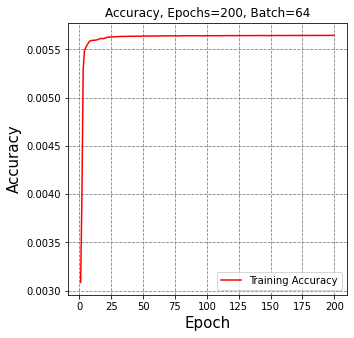

In [ ]:
plotLearningCurve2(r,Epochs1,Batch_size1)

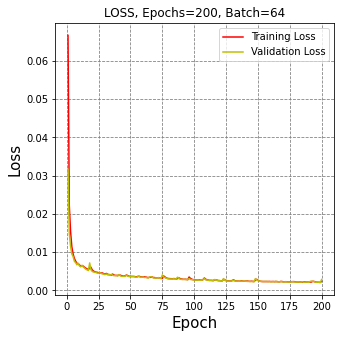

In [ ]:
plotLearningCurve1(r,Epochs1,Batch_size1)

In [ ]:
value1 = psnr(x_test_noisy[0], y_pred1[0].reshape(x_test[0].shape[0],-1))
value2 = psnr(x_test_noisy[0], median_blur)
value3 = psnr(x_test_noisy[0], gaussian_blur)
value4 = psnr(x_test_noisy[0], average_blur)
value5 = psnr(x_test_noisy[0], bilateral_filter)
metric = pd.DataFrame({'Autoencoder':value1,'Median Blur':value2,'Gaussian Blur':value3,'Average Blur':value4,'Bilateral Filter':value5},index = ['PSNR'])
value1 = mse(x_test_noisy[0], y_pred1[0].reshape(x_test_noisy[0].shape[0],-1))
value2 = mse(x_test_noisy[0], median_blur)
value3 = mse(x_test_noisy[0], gaussian_blur)
value4 = mse(x_test_noisy[0], average_blur)
value5 = mse(x_test_noisy[0], bilateral_filter)
metric.loc['MSE'] = [value1,value2,value3,value4,value5]
value1 = ssim(x_test_noisy[0], y_pred1[0].reshape(x_test_noisy[0].shape[0],-1))
value2 = ssim(x_test_noisy[0], median_blur)
value3 = ssim(x_test_noisy[0], gaussian_blur)
value4 = ssim(x_test_noisy[0], average_blur)
value5 = ssim(x_test_noisy[0], bilateral_filter)
metric.loc['SSIM'] = [value1,value2,value3,value4,value5]
metric

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


,Autoencoder,Median Blur,Gaussian Blur,Average Blur,Bilateral Filter
PSNR,24.330914,13.376437,13.372698,13.534356,13.702604
MSE,0.003689,0.045957,0.045997,0.044316,0.042632
SSIM,0.826425,0.226421,0.221807,0.227895,0.237656


In [ ]:
###===========================================THE END==========================================================###